In [1]:
import pandas as pd
import numpy as np
import pickle
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import keras

from pathlib import Path

2023-12-12 11:52:45.823607: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load data
cwd = Path.cwd()
moondf = pickle.load(open(cwd / '..' / 'raw_data' / 'moonGen_scrape_2016_with_labels', 'rb'))
# change the grade column from a number 4 - 14 to a list of 11 binary values
moondf['grade'] = moondf['grade'].apply(lambda x: [1 if i == x else 0 for i in range(4, 15)])
# one hot encode the grade column
grade_cols = ['V_' + str(i) for i in range(4, 15)]
moondf[grade_cols] = pd.DataFrame(moondf['grade'].to_list(), index=moondf.index)
y = moondf[grade_cols].values
X = moondf.drop(columns=grade_cols, axis=1)
X = X.drop(["is_benchmark", "repeats", "grade"], axis=1).values

In [3]:

# Now train a neutral network on the same data (using keras)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)


# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Input(shape=(141,)))
    model.add(Dense(128, kernel_initializer='normal', activation='relu'))
    model.add(Dense(128, kernel_initializer='normal', activation='relu'))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(11, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = baseline_model()


callbacks = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)]

model.fit(X_train, y_train, epochs=100, batch_size=512, verbose=1,
                            callbacks=callbacks, validation_data=(X_test, y_test))


history = model.history


2023-12-12 11:52:48.988603: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
48/48 [==============================] - 1s 8ms/step - loss: 2.0972 - accuracy: 0.3191 - val_loss: 1.6028 - val_accuracy: 0.2788
Epoch 2/100
48/48 [==============================] - 0s 5ms/step - loss: 1.5150 - accuracy: 0.3329 - val_loss: 1.4734 - val_accuracy: 0.3251
Epoch 3/100
48/48 [==============================] - 0s 5ms/step - loss: 1.4410 - accuracy: 0.3343 - val_loss: 1.4355 - val_accuracy: 0.3374
Epoch 4/100
48/48 [==============================] - 0s 5ms/step - loss: 1.4069 - accuracy: 0.3455 - val_loss: 1.4081 - val_accuracy: 0.3609
Epoch 5/100
48/48 [==============================] - 0s 4ms/step - loss: 1.3754 - accuracy: 0.3819 - val_loss: 1.3756 - val_accuracy: 0.3871
Epoch 6/100
48/48 [==============================] - 0s 4ms/step - loss: 1.3186 - accuracy: 0.4324 - val_loss: 1.3102 - val_accuracy: 0.4568
Epoch 7/100
48/48 [==============================] - 0s 5ms/step - loss: 1.2484 - accuracy: 0.4835 - val_loss: 1.2549 - val_accuracy: 0.4826
Epoch 8/100
4

192/192 [==============================] - 0s 946us/step
Accuracy: 48.56%


Text(0.5, 1.0, 'Confusion Matrix for FCNN Classifier')

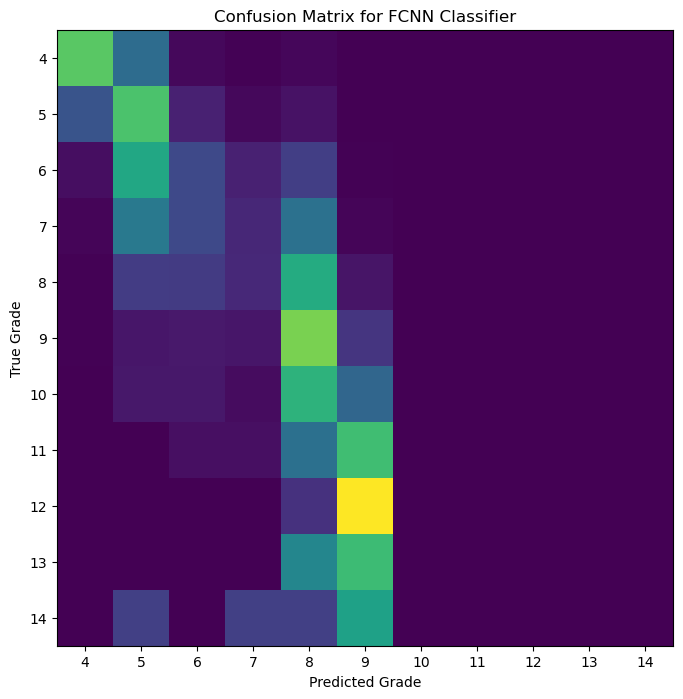

In [5]:
y_pred = model.predict(X_test)

accuracy = sklearn.metrics.accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
fig = plt.figure(figsize=(8, 8))
#plt.imshow(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm)
plt.xticks(np.arange(11), np.arange(4, 15))
plt.yticks(np.arange(11), np.arange(4, 15))
plt.xlabel('Predicted Grade')
plt.ylabel('True Grade')
plt.title('Confusion Matrix for FCNN Classifier')